Data: http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/

https://sci2s.ugr.es/keel/dataset.php?cod=113

* Thinking of a problem that's interesting for you and finding a dataset for that
* Describing this problem and explaining how a model could be used
* Preparing the data and doing EDA, analyzing important features
* Training multiple models, tuning their performance and selecting the best model
* Exporting the notebook into a script
* Putting your model into a web service and deploying it locally with docker
* Bonus points for deploying the service to the cloud

In [1]:
import pandas as pd
# import numpy as np
import seaborn as sns
import random
import sklearn
pd.set_option('display.max_rows', 200)
from statistics import mean


In [2]:
df = pd.read_csv('vowels_data.csv')
df

,train_test,speaker,sex,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,vowel
0,0,0,0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,0
1,0,0,0,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,1
2,0,0,0,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,2
3,0,0,0,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,3
4,0,0,0,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,1,14,1,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147,6
986,1,14,1,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301,7
987,1,14,1,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500,8
988,1,14,1,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390,9


In [88]:
def convert_to_vowel(vowel_int):
    convert = {
    0: 'hid',
	1: 'hId',		
	2: 'hEd',
	3: 'hAd',		
	4: 'hYd',		
	5: 'had',		
	6: 'hOd',		
	7: 'hod',		
	8: 'hUd',		
	9: 'hud',		
	10: 'hed'
    }
    return convert.get(vowel_int, "No vowel given")

In [3]:
df.drop(columns = "train_test", inplace = True)

In [4]:
df_test = df[df.speaker.isin([10, 11, 13, 14])]  # Two male and two female in df_test

In [5]:
df_train = df[df.speaker.isin([0,1,2,3,4,5,6,7,8,9,12])]
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [6]:
df_train.head()

,speaker,sex,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,vowel
0,3,0,-1.656,-0.496,-1.719,0.363,-0.002,1.637,0.535,1.319,-0.012,-0.490,0
1,1,0,-1.914,1.473,-1.342,-0.013,-0.213,0.253,0.005,0.229,-0.009,-0.445,3
2,1,0,-4.880,3.064,0.060,0.434,-0.575,0.897,0.250,0.085,0.093,0.445,9
3,12,1,-2.818,3.685,-1.413,-0.558,0.025,0.871,0.688,-0.144,-0.930,0.282,6
4,1,0,-4.161,2.937,0.157,0.336,-0.968,0.641,0.088,0.237,0.565,0.823,8


In [7]:
df_train.dtypes

speaker      int64
sex          int64
f0         float64
f1         float64
f2         float64
f3         float64
f4         float64
f5         float64
f6         float64
f7         float64
f8         float64
f9         float64
vowel        int64
dtype: object

It's tricky to know how to split the data for train/val/test. Although I have 990 rows of data, they are only spoken by 15 people, and it is reasonable to think that the person speaking is likely to have a significant impact on the data.

If I were to split the 990 rows randomly, I would have data leakage from the test data into the training data, since some of the training data would come from the same people who also produced test data.

Therefore I decided to split off the test data according to people. I chose two male and two female speakers to constitute the test data.

I considered whether or not I should take a similar approach for the validation data. In the end I decided to use a manual cross-validation, where I held back one person from the training data each time to be used for validation, and then took the mean of the evaluation metrics.

## Missing Values

In [8]:
df_train.isnull().sum()

speaker    0
sex        0
f0         0
f1         0
f2         0
f3         0
f4         0
f5         0
f6         0
f7         0
f8         0
f9         0
vowel      0
dtype: int64

## Exploration of features

<AxesSubplot:>

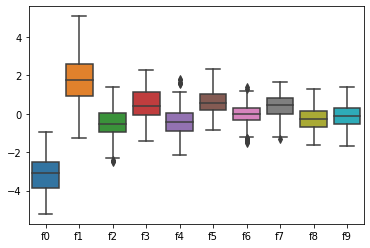

In [9]:
sns.boxplot(data = df_train[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']])

We need to shuffle the rows, because they're currently in speaker and vowel order.

## Build and test some initial models

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [122]:
def evaluate_model(model, df_train = df_train):
    speakers = df_train['speaker'].unique()
    scores = []
    accuracy = []
    for speaker in speakers:
        df_train = df_train.copy()
        X_train = df_train[df_train['speaker'] != speaker]
        X_val = df_train[df_train['speaker'] == speaker]
        y_train = df_train.loc[df_train['speaker'] != speaker]['vowel']
        y_val = df_train.loc[df_train['speaker'] == speaker]['vowel']
        model.fit(X_train.drop(['vowel', 'speaker'], axis=1), y_train)
        y_preds_proba = model.predict_proba(X_val.drop(['vowel', 'speaker'], axis=1))
        y_preds = model.predict(X_val.drop(['vowel', 'speaker'], axis=1))
        scores.append(roc_auc_score(y_val, y_preds_proba, multi_class='ovo'))
        accuracy.append(mean((y_preds == y_val).astype(int)))
    return mean(scores), mean(accuracy)

In [67]:
lr = LogisticRegression(multi_class="multinomial", solver='saga')
AUC, accuracy = evaluate_model(lr)
print(f'AUC: {AUC}\nAccuracy: {accuracy}')

/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: Conver

AUC: 0.9114784205693297
Accuracy: 0.4834710743801653


/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [12]:
rf = RandomForestClassifier()
AUC, accuracy = evaluate_model(rf)
print(f'AUC: {AUC}\nAccuracy: {accuracy}')

AUC: 0.9389807162534435
Accuracy: 0.5950413223140496


In [13]:
gb = GradientBoostingClassifier()
AUC, accuracy = evaluate_model(gb)
print(f'AUC: {AUC}\nAccuracy: {accuracy}')

AUC: 0.8944674012855831
Accuracy: 0.5206611570247934


## Tuning Hyperparameters

### Random Forest

In [17]:
n_estimators_list = [25, 50, 100, 200, 400, 800, 1600]

In [18]:
for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n)
    print(f'n_estimators: {n} \t AUC: {evaluate_model(rf)}')

n_estimators: 25 	 AUC: 0.9150367309458219
n_estimators: 50 	 AUC: 0.9451331496786042
n_estimators: 100 	 AUC: 0.9384871441689623
n_estimators: 200 	 AUC: 0.9446625344352617
n_estimators: 400 	 AUC: 0.9479912764003673


KeyboardInterrupt: 

In [ ]:
max_depth_list = [10, 15, 20, 30, 50]

In [ ]:
for m in max_depth_list:
    rf = RandomForestClassifier(n_estimators=400, max_depth=m)
    print(f'max_depth: {m} \t AUC: {evaluate_model(rf)}')

In [ ]:
for m in max_depth_list:
    rf = RandomForestClassifier(n_estimators=400, max_depth=15)
    print(f'max_depth: {m} \t AUC: {evaluate_model(rf)}')

### Best model

In [14]:
rf = RandomForestClassifier(n_estimators=400, max_depth=15)
AUC, accuracy = evaluate_model(rf)
print(f'AUC: {AUC}\nAccuracy: {accuracy}')

AUC: 0.94794536271809
Accuracy: 0.5964187327823691


## Exporting the Model

In [15]:
model = RandomForestClassifier(n_estimators=400, max_depth=15)
model.fit(df_train.drop(['vowel', 'speaker'], axis=1), df_train['vowel'])

RandomForestClassifier(max_depth=15, n_estimators=400)

In [16]:
import pickle 

with open('vowel-model.bin', 'wb') as f_out:
    pickle.dump((model), f_out)

## Test Example

A random example from the test data:

In [119]:
# Pick a random example from the test set

random_index = random.randint(0, df_test.shape[0] - 1)
random_index

example = df_test.drop(['speaker', 'vowel'], axis=1).iloc[[random_index,]]
example = example.to_dict()
vowel_int = df_test.iloc[random_index]['vowel'].astype(int)
convert_to_vowel(vowel_int)

'hEd'

This example, predicted from the locally run model:

In [120]:
vowel_int = model.predict(df_test.drop(['speaker', 'vowel'], axis=1).iloc[[random_index,]])[0]
convert_to_vowel(vowel_int)

'hEd'

This example, predicted from the Docker file:

In [121]:
import requests
url = 'http://localhost:9696/predict'
response = requests.post(url, json=example)
result = response.json()
result

{'Prediction': 'hEd'}

## Docker Deployment

To build, make sure you're in the directory containing the Dockerfile, Pipfile, Pipfile.lock, vowel-model.bin and predict_vowel.py. Then: 

```sudo docker build -t zoomcamp-midterm .```

To run:

```sudo docker run -it --rm -p 9696:9696 zoomcamp-midterm:latest```